# MPIIFaceGaze Processing

From their website,

*Annotation*

There are pxx.txt file in each participant folder. which saves the information:

- Dimension 1: image file path and name.
- Dimension 2~3: Gaze location on the screen coordinate in pixels, the actual screen size can be found in the "Calibration" folder.
- Dimension 4~15: (x,y) position for the six facial landmarks, which are four eye corners and two mouth corners.
- Dimension 16~21: The estimated 3D head pose in the camera coordinate system based on 6 points-based 3D face model, rotation and translation: we implement the same 6 points-based 3D face model in [1], which includes the four eye corners and two mouth corners.
- Dimension 22~24 (fc): Face center in the camera coordinate system, which is averaged 3D location of the 6 focal landmarks face model. Not it is slightly different with the head translation due to the different centers of head and face.
- Dimension 25~27 (gt): The 3D gaze target location in the camera coordinate system. The gaze direction can be calculated as gt - fc.
- Dimension 28: Which eye (left or right) is used for the evaluation subset in [2].

*Calibration*

There is the "Calibration" folder for each participant, which contains

- (1) Camera.mat: the intrinsic parameter of the laptop camera. "cameraMatrix": the projection matrix of the camera. "distCoeffs": camera distortion coefficients. "retval": root mean square (RMS) re-projection error. "rvecs": the rotation vectors. "tvecs": the translation vectors.
- (2) monitorPose.mat: the position of image plane in camera coordinate. "rvecs": the rotation vectors. "tvecs": the translation vectors.
- (3) screenSize.mat: the laptop screen size. "height_pixel": the screen height in pixel. "width_pixel": the screen width in pixel. "height_mm": the screen height in millimeter. "width_mm": the screen width in millimeter.

In [1]:
!pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)


In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

In [6]:
%pwd

'/home/sagemaker-user/gesture-gaze-extension/notebooks'

In [15]:
DATA_DIR = '/home/sagemaker-user/gesture-gaze-extension/datasets/MPIIFaceGaze'
DATA_PROC_IMG_DIR = '/home/sagemaker-user/gesture-gaze-extension/datasets/MPIIFaceGazeProcessed/images'
DATA_PROC_JSON_DIR = '/home/sagemaker-user/gesture-gaze-extension/datasets/MPIIFaceGazeProcessed/ann.json'

## Convert (gt - fc) to pitch/yaw and back

In [6]:
def vector_to_pitchyaw(vec3d):
    x, y, z = vec3d
    norm = np.linalg.norm(vec3d)
    x /= norm
    y /= norm
    z /= norm
    pitch = np.arcsin(-y)  # vertical angle
    yaw = np.arctan2(-x, -z)  # horizontal angle
    return np.array([pitch, yaw])


def pitchyaw_to_vector(pitch, yaw):
    x = -np.sin(yaw)
    y = -np.sin(pitch)
    return np.array([x, y])

## Loading

In [7]:
def draw_gaze_from_pupils(img, gaze_vec, l_pupil, r_pupil, color=(0, 255, 0), scale=50):
    img = img.copy()
    l_pt = (round(l_pupil[0]), round(l_pupil[1]))
    r_pt = (round(r_pupil[0]), round(r_pupil[1]))

    l_end = (round(l_pt[0] + gaze_vec[0] * scale), round(l_pt[1] + gaze_vec[1] * scale))
    r_end = (round(r_pt[0] + gaze_vec[0] * scale), round(r_pt[1] + gaze_vec[1] * scale))

    cv2.arrowedLine(img, l_pt, l_end, color, 2, tipLength=0.1)
    cv2.arrowedLine(img, r_pt, r_end, color, 2, tipLength=0.1)  # red from right eye
    return img

In [8]:
def auto_crop_non_black(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = (gray > 10).astype(np.uint8)
    coords = cv2.findNonZero(mask)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]
    return cropped, (x, y)

In [9]:
def visualize_n_gaze_samples(base_dir, participant="p00", n=10, target_size=(224, 224)):
    txt_path = os.path.join(base_dir, participant, f"{participant}.txt")
    with open(txt_path, "r") as f:
        lines = f.readlines()

    count = 0
    for line in lines:
        if count >= n:
            break

        tokens = line.strip().split()
        img_rel = tokens[0]
        img_path = os.path.join(base_dir, participant, img_rel)

        img_raw = cv2.imread(img_path)
        if img_raw is None:
            continue

        original_h, original_w = img_raw.shape[:2]
        img_cropped, offset = auto_crop_non_black(img_raw)
        crop_x, crop_y = offset
        crop_h, crop_w = img_cropped.shape[:2]
        img = cv2.resize(img_cropped, target_size)

        # landmarks
        lx1, ly1 = float(tokens[3]) - crop_x, float(tokens[4]) - crop_y
        lx2, ly2 = float(tokens[5]) - crop_x, float(tokens[6]) - crop_y
        rx1, ry1 = float(tokens[7]) - crop_x, float(tokens[8]) - crop_y
        rx2, ry2 = float(tokens[9]) - crop_x, float(tokens[10]) - crop_y

        l_pupil_raw = [(lx1 + lx2) / 2, (ly1 + ly2) / 2]
        r_pupil_raw = [(rx1 + rx2) / 2, (ry1 + ry2) / 2]

        scale_x = target_size[0] / crop_w
        scale_y = target_size[1] / crop_h

        l_pupil = [l_pupil_raw[0] * scale_x, l_pupil_raw[1] * scale_y]
        r_pupil = [r_pupil_raw[0] * scale_x, r_pupil_raw[1] * scale_y]

        # gaze vector
        gt = np.array([float(tokens[24]), float(tokens[25]), float(tokens[26])])
        fc = np.array([float(tokens[21]), float(tokens[22]), float(tokens[23])])
        gaze_vec3d = gt - fc

        pitch, yaw = vector_to_pitchyaw(gaze_vec3d)
        gaze_vec2d = pitchyaw_to_vector(pitch, yaw)

        vis = draw_gaze_from_pupils(img, gaze_vec2d, l_pupil, r_pupil, color=(0, 255, 0), scale=100)
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title(f"Sample {count+1}: Green = GT Gaze Direction")
        plt.axis("off")
        plt.show()

        count += 1

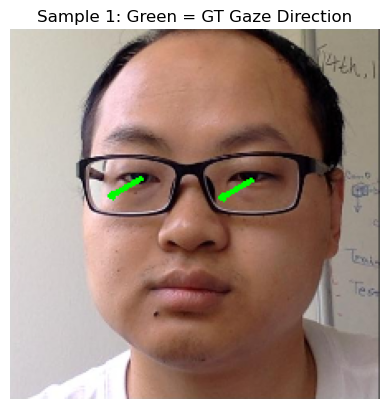

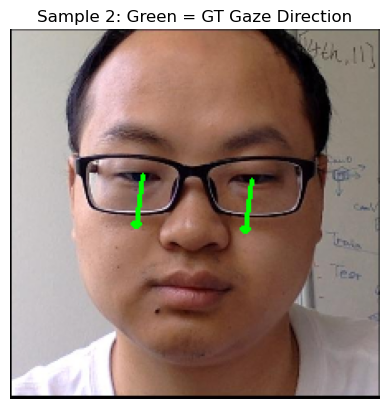

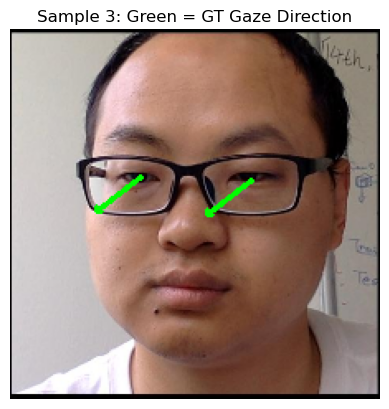

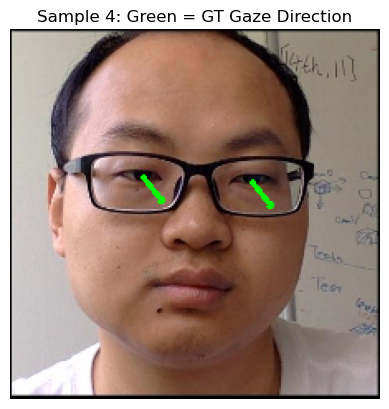

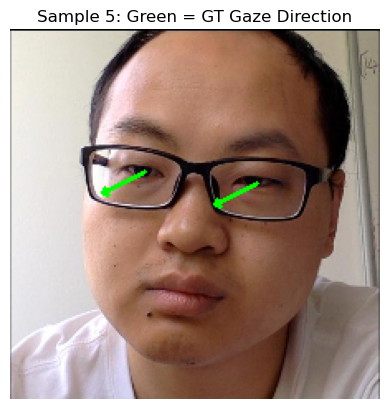

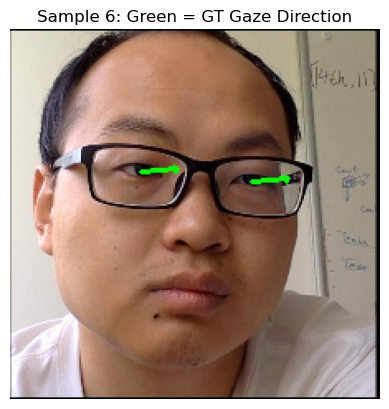

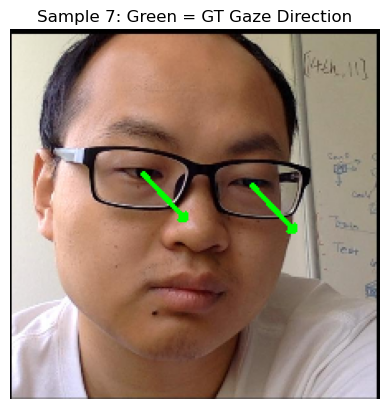

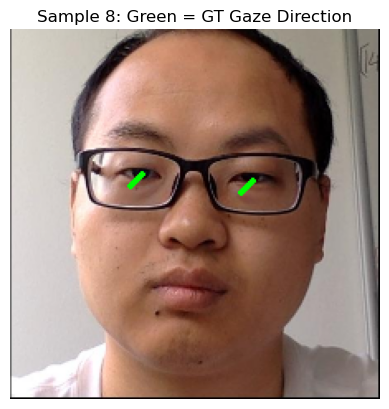

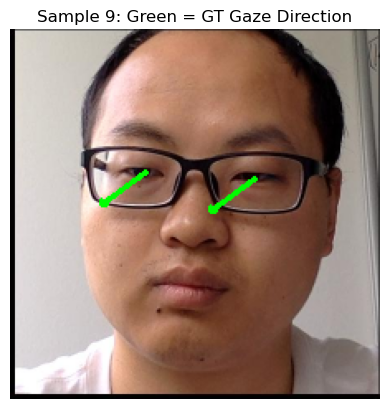

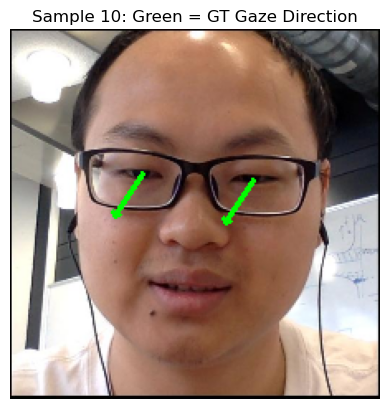

In [10]:
visualize_n_gaze_samples(DATA_DIR, participant="p01", n=10)

In [11]:
def preprocess_mpiifacegaze(
    dataset_root,
    output_img_dir,
    output_json_path,
    participants=['p00', 'p01'],
    target_size=(224, 224)
):
    os.makedirs(output_img_dir, exist_ok=True)
    all_annotations = []

    for pid in participants:
        txt_path = os.path.join(dataset_root, pid, f"{pid}.txt")
        with open(txt_path, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc=f"Processing {pid}"):
            tokens = line.strip().split()
            img_rel = tokens[0]
            img_path = os.path.join(dataset_root, pid, img_rel)

            img_raw = cv2.imread(img_path)
            if img_raw is None:
                continue

            try:
                img_cropped, offset = auto_crop_non_black(img_raw)
                crop_x, crop_y = offset
                crop_h, crop_w = img_cropped.shape[:2]
                img_resized = cv2.resize(img_cropped, target_size)

                # Adjust and scale landmarks
                lx1, ly1 = float(tokens[3]) - crop_x, float(tokens[4]) - crop_y
                lx2, ly2 = float(tokens[5]) - crop_x, float(tokens[6]) - crop_y
                rx1, ry1 = float(tokens[7]) - crop_x, float(tokens[8]) - crop_y
                rx2, ry2 = float(tokens[9]) - crop_x, float(tokens[10]) - crop_y

                l_pupil_raw = [(lx1 + lx2) / 2, (ly1 + ly2) / 2]
                r_pupil_raw = [(rx1 + rx2) / 2, (ry1 + ry2) / 2]

                scale_x = target_size[0] / crop_w
                scale_y = target_size[1] / crop_h

                l_pupil = [l_pupil_raw[0] * scale_x, l_pupil_raw[1] * scale_y]
                r_pupil = [r_pupil_raw[0] * scale_x, r_pupil_raw[1] * scale_y]

                # Compute gaze pitch/yaw
                gt = np.array([float(tokens[24]), float(tokens[25]), float(tokens[26])])
                fc = np.array([float(tokens[21]), float(tokens[22]), float(tokens[23])])
                pitch, yaw = vector_to_pitchyaw(gt - fc)

                # Save image
                save_name = f"{pid}_{img_rel.replace('/', '_')}"
                save_path = os.path.join(output_img_dir, save_name)
                cv2.imwrite(save_path, (img_resized * 255).astype(np.uint8) if img_resized.max() <= 1.0 else img_resized)

                # Store annotation
                all_annotations.append({
                    "img": save_name,
                    "l_pupil": l_pupil,
                    "r_pupil": r_pupil,
                    "pitch": pitch,
                    "yaw": yaw
                })

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

    with open(output_json_path, 'w') as f:
        json.dump(all_annotations, f, indent=2)

In [12]:
preprocess_mpiifacegaze(
    dataset_root=DATA_DIR,
    output_img_dir=DATA_PROC_IMG_DIR,
    output_json_path=DATA_PROC_JSON_DIR,
    participants=["p00", "p01"]
)

Processing p01: 100%|██████████| 2904/2904 [00:21<00:00, 132.06it/s]


In [13]:
def visualize_json_dataset(json_path, img_dir, n=10, scale=100):
    with open(json_path, 'r') as f:
        annotations = json.load(f)

    for i, sample in enumerate(annotations[:n]):
        img_path = os.path.join(img_dir, sample['img'])
        img = cv2.imread(img_path)
        if img is None:
            continue

        l_pupil = sample['l_pupil']
        r_pupil = sample['r_pupil']
        pitch = sample['pitch']
        yaw = sample['yaw']
        gaze_vec = pitchyaw_to_vector(pitch, yaw)

        vis = draw_gaze_from_pupils(img, gaze_vec, l_pupil, r_pupil, color=(0, 255, 0), scale=scale)
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title(f"Sample {i+1}: GT Gaze")
        plt.axis("off")
        plt.show()

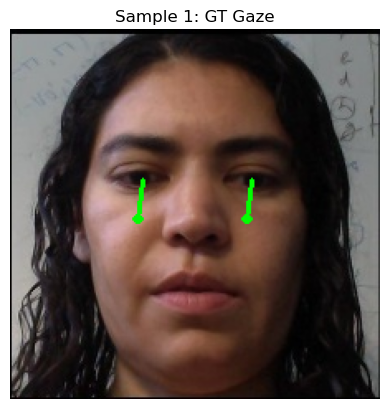

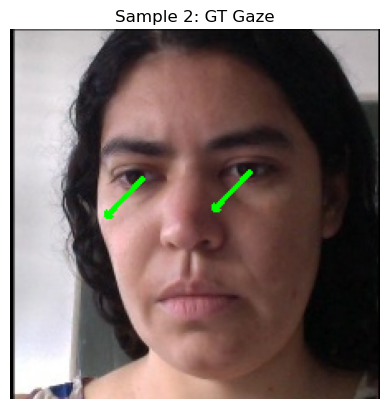

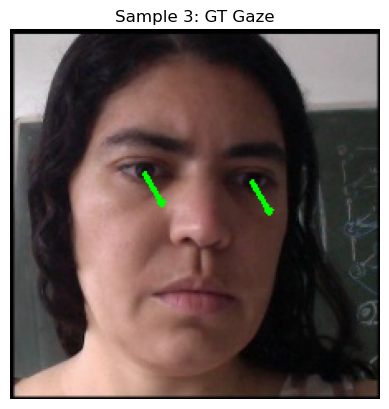

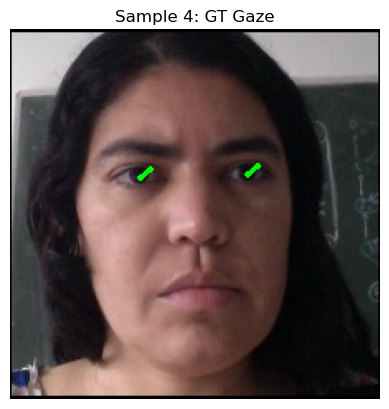

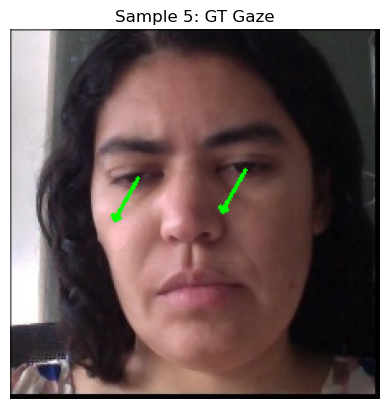

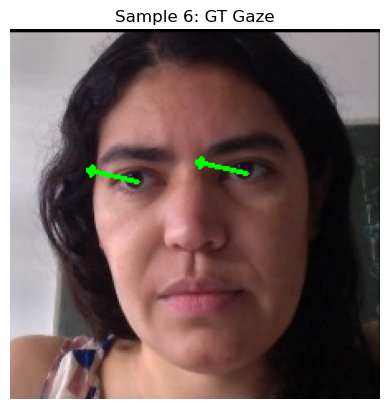

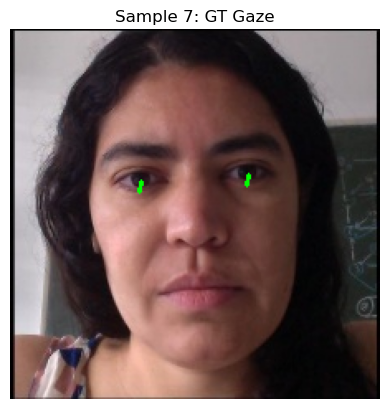

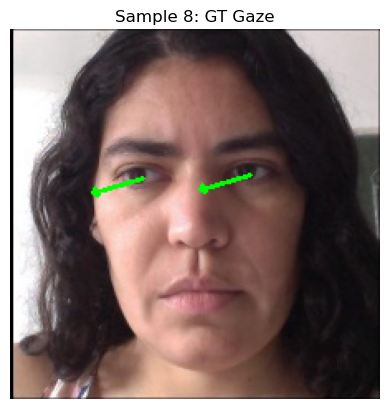

In [16]:
visualize_json_dataset(DATA_PROC_JSON_DIR, DATA_PROC_IMG_DIR, n=8)